# Modelo de Regresión para la Laguna de Torrevieja

In [1]:
# !pip install skforecast

In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from scipy import stats

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster

from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import  KNeighborsRegressor
from sklearn import linear_model

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

from skforecast.utils import load_forecaster

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers,callbacks
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Input


# Calculo de metricas
# ==============================================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn import metrics

# Configuración warnings
# ==============================================================================
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
# warnings.filterwarnings('ignore')

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def evaluacion_metrica(test, predictions, modelo, hereda, reentrena, horizonte):
  r2 = r2_score(test, predictions)
  mse = mean_squared_error(test, predictions)
  mae = mean_absolute_error(test, predictions)

  resultados = pd.DataFrame({'Modelo':[modelo],
                              'Horizonte':[horizonte],
                              'Hereda':[hereda],
                              'Reentrena':[reentrena],
                              'r2':[r2],
                              'MSE':[mse],
                              'MAE':[mae]})

  return resultados

## Preparación de los datos

In [4]:
folder = "./data/"
parametro = 'temperatura'
output=parametro
inputs = [
          'fecha', 'temperatura',
          'ambiente', 'nivel'
          ]
usecols = inputs.copy()

datos = pd.read_csv(folder + "laguna_datos_horarios_rellenos" + ".csv",sep=',', usecols=usecols)

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%d/%m/%Y %H:%M')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('H')
datos = datos.sort_index()

datos.info()

datos

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2113 entries, 2023-06-17 00:00:00 to 2023-09-13 00:00:00
Freq: h
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  2113 non-null   float64
 1   ambiente     2113 non-null   float64
 2   nivel        2113 non-null   float64
dtypes: float64(3)
memory usage: 66.0 KB


C:\Users\Vir\AppData\Local\Temp\ipykernel_16948\2227988070.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datos = datos.asfreq('H')


,temperatura,ambiente,nivel
fecha,,,
2023-06-17 00:00:00,31.5000,22.000000,51.0
2023-06-17 01:00:00,31.4700,21.780000,51.0
2023-06-17 02:00:00,31.2350,21.201000,47.8
2023-06-17 03:00:00,31.2950,22.439250,52.0
2023-06-17 04:00:00,31.3750,23.058375,50.0
...,...,...,...
2023-09-12 20:00:00,31.5375,25.820000,34.0
2023-09-12 21:00:00,31.4325,25.310000,36.0
2023-09-12 22:00:00,31.3350,23.930000,35.0


Limpieza de datos anómalos

## Predecir T

In [5]:
datos["t-1"] = datos["temperatura"].shift(1)
datos = datos.dropna()

datos.tail(10)

,temperatura,ambiente,nivel,t-1
fecha,,,,
2023-09-12 15:00:00,30.3750,27.69,31.0,30.1025
2023-09-12 16:00:00,30.5875,27.56,37.0,30.3750
2023-09-12 17:00:00,30.7450,27.40,34.0,30.5875
2023-09-12 18:00:00,30.7500,26.82,37.0,30.7450
2023-09-12 19:00:00,31.1600,25.94,34.0,30.7500
2023-09-12 20:00:00,31.5375,25.82,34.0,31.1600
2023-09-12 21:00:00,31.4325,25.31,36.0,31.5375
2023-09-12 22:00:00,31.3350,23.93,35.0,31.4325
2023-09-12 23:00:00,31.1775,23.70,35.0,31.3350


## Preparar los datos de train y test

In [6]:
horizonte = 420

datos_dif = datos.iloc[:] #JUGAR CON LOS VALORES DE "X:Y" PARA MARCAR LA SERIE TEMPORAL QUE SE QUIERE
datos_pred = datos_dif.iloc[:-horizonte] # PARA TENER UNA COPIA DEL ORIGINAL Y MODIFICAR LA COPIA
predicciones = pd.DataFrame() #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO

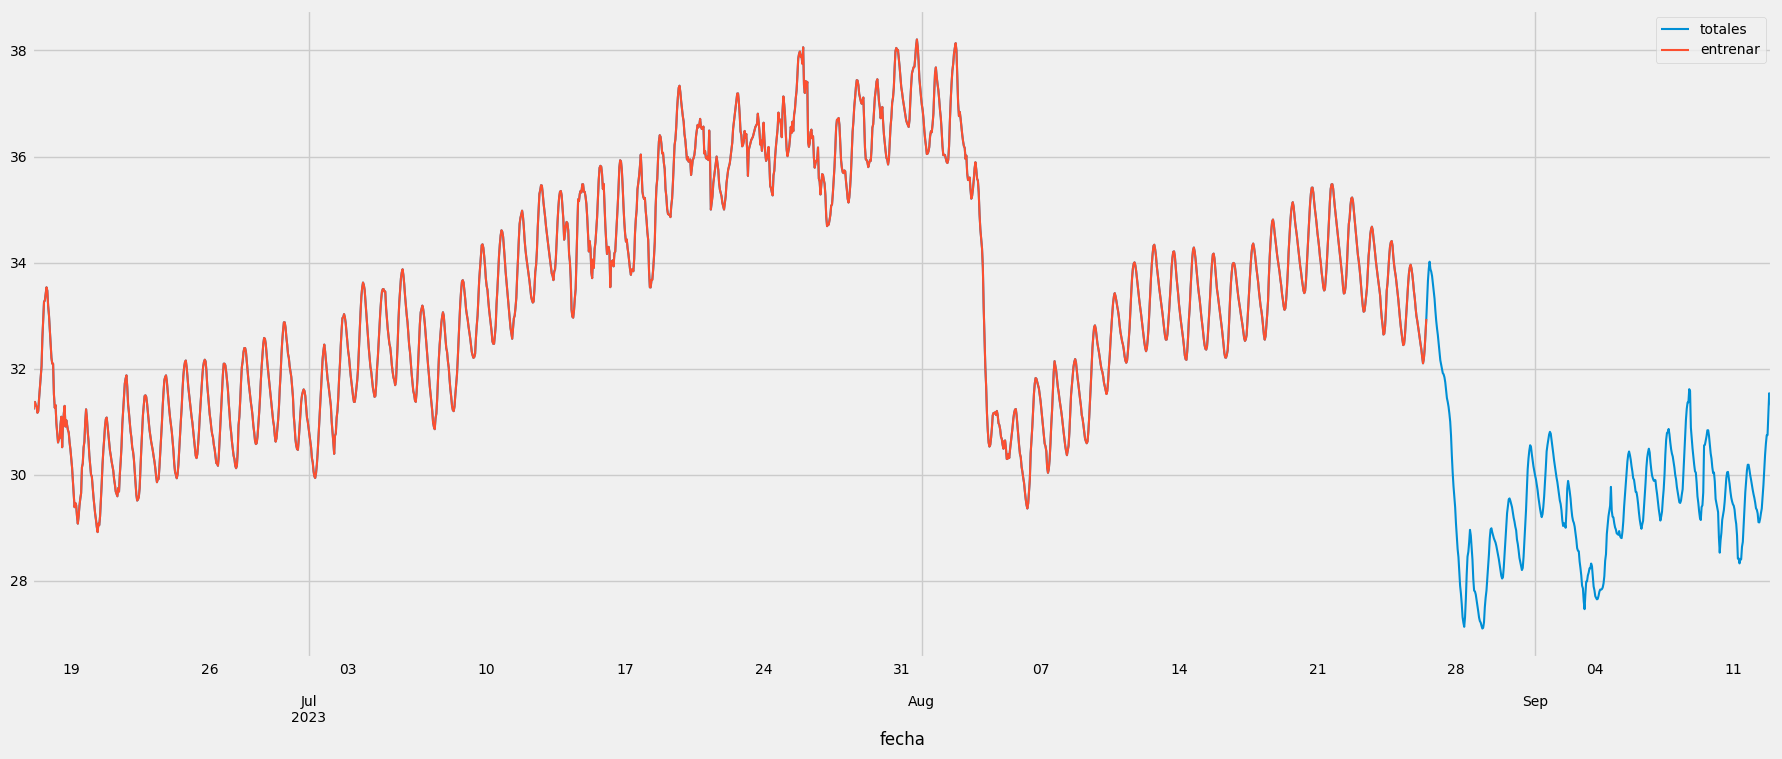

In [7]:
fig, ax = plt.subplots(figsize=(20, 8))
datos_dif['temperatura'].plot(ax=ax, label='totales')
datos_pred['temperatura'].plot(ax=ax, label='entrenar')
ax.legend();

In [8]:
def SARIMA_model_ambiente(train):
    # fit model
    model = SARIMAX(train['ambiente'], order=(3, 1, 1), seasonal_order=(2, 0, 1, 24))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.predict(len(train), len(train) + horizonte + 1)
    res=pd.DataFrame({"Pred":yhat})
    return res


def SARIMA_model_nivel(train):
    # fit model
    model = SARIMAX(train['nivel'], order=(3, 1, 1), seasonal_order=(2, 0, 1, 24))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.predict(len(train), len(train) + horizonte + 1)
    res=pd.DataFrame({"Pred":yhat})
    return res

def AR_model_ambiente(train):
    # fit model
    model = AutoReg(train['ambiente'], lags=24)
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.predict(len(train), len(train) + horizonte + 1)
    res=pd.DataFrame({"Pred":yhat})
    return res


def AR_model_nivel(train):
    # fit model
    model = AutoReg(train['nivel'], lags=24)
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.predict(len(train), len(train) + horizonte + 1)
    res=pd.DataFrame({"Pred":yhat})
    return res

In [9]:
df_ret_ambiente_SARIMA = SARIMA_model_ambiente(datos_pred)
df_ret_nivel_SARIMA = SARIMA_model_nivel(datos_pred)
df_ret_ambiente_AR = AR_model_ambiente(datos_pred)
df_ret_nivel_AR = AR_model_nivel(datos_pred)

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Reentrenando Sí o No

In [10]:
def entrenando(predicciones,datos_pred,modelo,datos_ambiente,datos_nivel,opcion):
    i=0
    while i < horizonte+1:
        X_train = datos_pred[["t-1","ambiente","nivel"]].iloc[:-1]
        y_train = datos_pred["temperatura"].iloc[:-1]
        X_test = datos_pred[["t-1","ambiente","nivel"]].iloc[-1]

        modelo.fit(X_train.values, y_train.values)

        y_pred = modelo.predict(X_test.values.reshape(1, -1))

        datos_pred["temperatura"].iloc[-1] = y_pred

        fecha = datos_pred.tail(1).index + pd.Timedelta(hours=1)
        fecha2 = datos_pred.tail(1).index #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO

        if (opcion == 0):
            new_row = {'t-1':datos_pred["temperatura"].iloc[-1],
                       'ambiente':datos_ambiente.iloc[-1],
                       'nivel':datos_nivel.iloc[-1],
                       'temperatura':y_pred[0]}
        else:
            new_row = {'t-1':datos_pred["temperatura"].iloc[-1],
                       'ambiente':datos_ambiente.iloc[i],
                       'nivel':datos_nivel.iloc[i],
                       'temperatura':y_pred[0]}

        datos_nuevos = pd.DataFrame([new_row], index=fecha)
        datos_nuevos2 = pd.DataFrame([new_row], index=fecha2) #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO

        datos_pred = pd.concat([datos_pred, datos_nuevos])
        predicciones = pd.concat([predicciones, datos_nuevos2]) #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO
        i = i + 1
    return(predicciones)

In [11]:
def sin_entrenar(predicciones,datos_pred,modelo,datos_ambiente,datos_nivel,opcion):
    i=0
    while i < horizonte+1:
        X_test = datos_pred[["t-1","ambiente","nivel"]].iloc[-1]
        y_pred = modelo.predict(X_test.values.reshape(1, -1))

        datos_pred["temperatura"].iloc[-1] = y_pred

        fecha = datos_pred.tail(1).index + pd.Timedelta(hours=1)
        fecha2 = datos_pred.tail(1).index #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO

        if (opcion == 0):
            new_row = {'t-1':datos_pred["temperatura"].iloc[-1],
                       'ambiente':datos_ambiente.iloc[-1],
                       'nivel':datos_nivel.iloc[-1],
                       'temperatura':y_pred[0]}
        else:
            new_row = {'t-1':datos_pred["temperatura"].iloc[-1],
                       'ambiente':datos_ambiente.iloc[i],
                       'nivel':datos_nivel.iloc[i],
                       'temperatura':y_pred[0]}

        datos_nuevos = pd.DataFrame([new_row], index=fecha)
        datos_nuevos2 = pd.DataFrame([new_row], index=fecha2) #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO

        datos_pred = pd.concat([datos_pred, datos_nuevos])
        predicciones = pd.concat([predicciones, datos_nuevos2]) #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO
        i = i + 1
    return(predicciones)

In [12]:
def guardar_resultados(resultados):
  resultados.to_excel('resultados.xlsx', sheet_name='Experimentos_3',index=False)
  df = pd.DataFrame(resultados)
  df = df.round(2)
  latex_code = df.to_latex(index=False, float_format="%.2f")
  print(latex_code)

## Modelos

In [13]:
predicciones_4_6 = predicciones.iloc[0:0]
datos_pred = datos_dif.iloc[:-horizonte]
X_train = datos_pred[["t-1","ambiente","nivel"]].iloc[:-1]
y_train = datos_pred["temperatura"].iloc[:-1]
model_MLP6 = MLPRegressor(hidden_layer_sizes=(32,32), learning_rate_init=0.01, max_iter=400, random_state=1).fit(X_train.values, y_train.values)
predicciones_4_6 = sin_entrenar(predicciones_4_6,datos_pred,model_MLP6,df_ret_ambiente_AR["Pred"],df_ret_nivel_AR["Pred"],1)


C:\Users\Vir\AppData\Local\Temp\ipykernel_16948\531090665.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  datos_pred["temperatura"].iloc[-1] = y_pred
C:\Users\Vir\AppData\Local\Temp\ipykernel_16948\531090665.py:7: FutureWarning: ChainedA

In [14]:
predicciones_4_6

,t-1,ambiente,nivel,temperatura
fecha,,,,
2023-08-26 12:00:00,32.770455,31.257026,37.154379,32.770455
2023-08-26 13:00:00,32.908236,31.567134,36.978578,32.908236
2023-08-26 14:00:00,33.052515,32.115516,37.110398,33.052515
2023-08-26 15:00:00,33.212336,32.285981,37.109776,33.212336
2023-08-26 16:00:00,33.371295,31.999113,37.143576,33.371295
...,...,...,...,...
2023-09-12 20:00:00,32.436365,27.600589,36.451307,32.436365
2023-09-12 21:00:00,32.438555,27.607217,36.449562,32.438555
2023-09-12 22:00:00,32.440917,27.610200,36.447819,32.440917


In [15]:
predicciones_4_4 = predicciones.iloc[0:0]
datos_pred = datos_dif.iloc[:-horizonte]
X_train = datos_pred[["t-1","ambiente","nivel"]].iloc[:-1]
y_train = datos_pred["temperatura"].iloc[:-1]
model_MLP4 = MLPRegressor(hidden_layer_sizes=(32,32), learning_rate_init=0.01, max_iter=400, random_state=1).fit(X_train.values, y_train.values)
predicciones_4_4 = sin_entrenar(predicciones_4_4,datos_pred,model_MLP4,df_ret_ambiente_SARIMA["Pred"],df_ret_nivel_SARIMA["Pred"],1)


C:\Users\Vir\AppData\Local\Temp\ipykernel_16948\531090665.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  datos_pred["temperatura"].iloc[-1] = y_pred
C:\Users\Vir\AppData\Local\Temp\ipykernel_16948\531090665.py:7: FutureWarning: ChainedA

In [16]:
predicciones_5_6 = predicciones.iloc[0:0]
datos_pred = datos_dif.iloc[:-horizonte]
X_train = datos_pred[["t-1","ambiente","nivel"]].iloc[:-1]
y_train = datos_pred["temperatura"].iloc[:-1]
model_Lasso6 = Lasso().fit(X_train.values, y_train.values)
predicciones_5_6 = sin_entrenar(predicciones_5_6,datos_pred,model_Lasso6,df_ret_ambiente_AR["Pred"],df_ret_nivel_AR["Pred"],1)


C:\Users\Vir\AppData\Local\Temp\ipykernel_16948\531090665.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  datos_pred["temperatura"].iloc[-1] = y_pred
C:\Users\Vir\AppData\Local\Temp\ipykernel_16948\531090665.py:7: FutureWarning: ChainedA

In [17]:
start_date = "2023-08-08 15:00"
end_date = "2023-09-13 00:00"
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

date_range

C:\Users\Vir\AppData\Local\Temp\ipykernel_16948\2148517697.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='H')


DatetimeIndex(['2023-08-08 15:00:00', '2023-08-08 16:00:00',
               '2023-08-08 17:00:00', '2023-08-08 18:00:00',
               '2023-08-08 19:00:00', '2023-08-08 20:00:00',
               '2023-08-08 21:00:00', '2023-08-08 22:00:00',
               '2023-08-08 23:00:00', '2023-08-09 00:00:00',
               ...
               '2023-09-12 15:00:00', '2023-09-12 16:00:00',
               '2023-09-12 17:00:00', '2023-09-12 18:00:00',
               '2023-09-12 19:00:00', '2023-09-12 20:00:00',
               '2023-09-12 21:00:00', '2023-09-12 22:00:00',
               '2023-09-12 23:00:00', '2023-09-13 00:00:00'],
              dtype='datetime64[ns]', length=850, freq='h')

In [18]:
plt.rcdefaults()

In [19]:
train = y_train[1263:]
train

fecha
2023-08-08 16:00:00    32.0400
2023-08-08 17:00:00    32.1325
2023-08-08 18:00:00    32.1825
2023-08-08 19:00:00    32.1200
2023-08-08 20:00:00    31.9575
                        ...   
2023-08-26 07:00:00    32.2225
2023-08-26 08:00:00    32.1025
2023-08-26 09:00:00    32.1800
2023-08-26 10:00:00    32.3675
2023-08-26 11:00:00    32.6475
Freq: h, Name: temperatura, Length: 428, dtype: float64

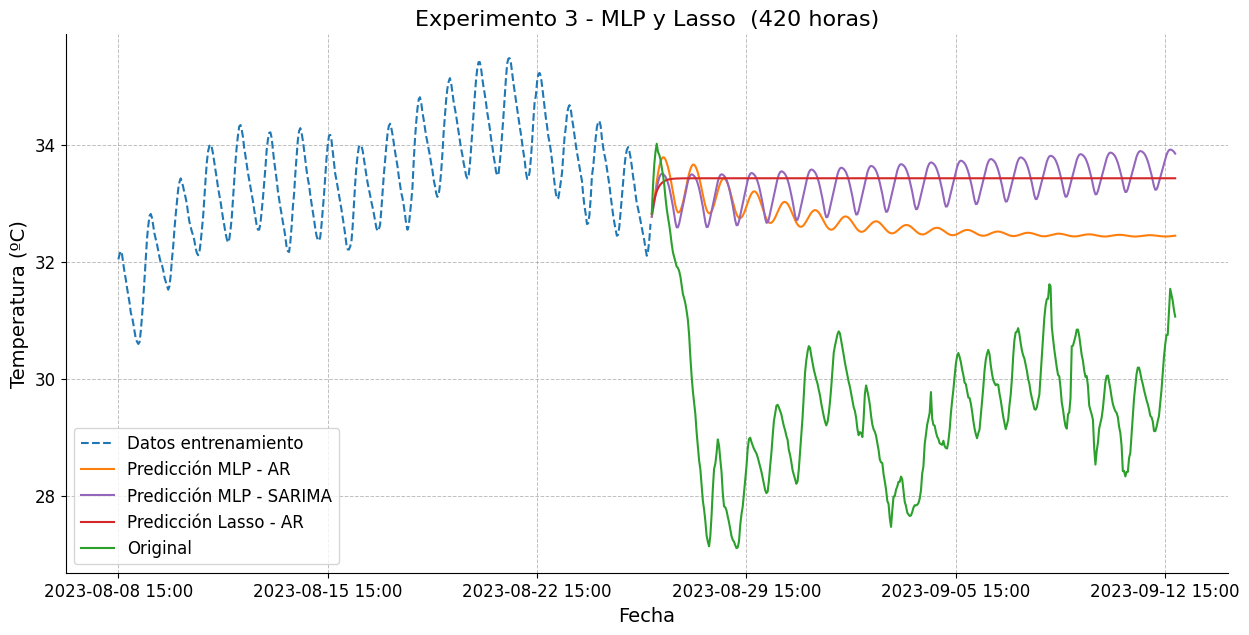

In [20]:
train = y_train[1263:]
import numpy as np
plt.figure(figsize=(15,7))
plt.plot(np.arange(len(train)), train, label='Datos entrenamiento', linestyle='--')
plt.plot(np.arange(len(train), len(train) + len(datos_dif['temperatura'].tail(horizonte+1))), predicciones_4_6["temperatura"], label='Predicción MLP - AR')
plt.plot(np.arange(len(train), len(train) + len(datos_dif['temperatura'].tail(horizonte+1))), predicciones_4_4["temperatura"], label='Predicción MLP - SARIMA', color = "#9467bd")
plt.plot(np.arange(len(train), len(train) + len(datos_dif['temperatura'].tail(horizonte+1))), predicciones_5_6["temperatura"], label='Predicción Lasso - AR', color = "#d62728")
plt.plot(np.arange(len(train), len(train) + len(datos_dif['temperatura'].tail(horizonte+1))), datos_dif['temperatura'].tail(horizonte+1), label='Original', color = "#2ca02c")


# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Experimento 3 - MLP y Lasso  (420 horas)', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

ax.set_xticks(np.arange(len(date_range))[::168])  # Mostrar ticks cada 168 horas (una semana)
ax.set_xticklabels(date_range[::168].strftime('%Y-%m-%d %H:%M'))

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"exp3.png", dpi=300, bbox_inches='tight')
plt.show()